# Dental Implant Classification with EfficientNetB3

This notebook implements transfer learning using EfficientNetB3 for dental implant classification in radiographic images. The implementation follows a progressive training approach with gradual unfreezing of layers.

## Overview
1. Data preparation and augmentation
2. EfficientNetB3 model setup
3. Progressive training implementation
4. Performance evaluation
5. Visualization of results

## 1. Setup and Imports

In [ ]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import datetime
from tqdm import tqdm
import cv2
import random
from collections import Counter

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths to your data in Google Drive
ROOT_DIR = '/content/drive/MyDrive/dental_implant_project'
DATA_DIR = os.path.join(ROOT_DIR, 'data_processed')  # Changed this
PROCESSED_DATA_DIR = DATA_DIR  # Simplified since data_processed is directly in dental_implant_project
TRAIN_DIR = os.path.join(PROCESSED_DATA_DIR, 'train')
VAL_DIR = os.path.join(PROCESSED_DATA_DIR, 'val')
TEST_DIR = os.path.join(PROCESSED_DATA_DIR, 'test')
RESULTS_DIR = os.path.join(ROOT_DIR, 'results')
MODEL_SAVE_DIR = os.path.join(RESULTS_DIR, 'models')
PLOTS_DIR = os.path.join(RESULTS_DIR, 'plots')
METRICS_DIR = os.path.join(RESULTS_DIR, 'metrics')

# Create directories if they don't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

# Try to enable mixed precision for better performance on compatible GPUs
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")

# Define memory cleanup function
def cleanup_memory():
    import gc
    tf.keras.backend.clear_session()
    gc.collect()
    print("Memory cleaned up")

# Set image parameters
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 16  # Adjust based on your GPU memory

Mounted at /content/drive
TensorFlow version: 2.18.0
GPU Available:  True
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision enabled


## 2. Data Preparation and Augmentation

In [ ]:
# Get class information
classes = sorted(os.listdir(TRAIN_DIR))
num_classes = len(classes)
print(f"Number of implant classes: {num_classes}")

# Function to get class weights to handle imbalance
def calculate_class_weights(directory):
    """Calculate class weights inversely proportional to class frequencies"""
    class_counts = {}
    total_samples = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            total_samples += count

    # Calculate weights inversely proportional to class frequency
    class_weights = {}
    for i, class_name in enumerate(sorted(class_counts.keys())):
        class_weights[i] = total_samples / (num_classes * class_counts[class_name])

    return class_weights

# Calculate class weights
class_weights = calculate_class_weights(TRAIN_DIR)

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Minimal augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print dataset information
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {valid_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

# Display sample class weights
print("\nSample class weights:")
for i, (class_name, weight) in enumerate(zip(sorted(train_generator.class_indices.keys()),
                                           [class_weights[i] for i in range(min(5, num_classes))])):
    print(f"  {class_name}: {weight:.2f}")
print("  ...")

Number of implant classes: 10
Found 8474 images belonging to 10 classes.
Found 1847 images belonging to 10 classes.
Found 1853 images belonging to 10 classes.
Training samples: 8474
Validation samples: 1847
Test samples: 1853
Class indices: {'ADIN': 0, 'Bego': 1, 'Bicon': 2, 'DIONAVI': 3, 'Dentium': 4, 'ITI': 5, 'MIS': 6, 'NORIS': 7, 'nobel': 8, 'osstem': 9}

Sample class weights:
  ADIN: 1.32
  Bego: 2.03
  Bicon: 0.25
  DIONAVI: 121.06
  Dentium: 2.57
  ...


## 3. EfficientNetB3 Model Setup

In [ ]:
def build_efficientnet_model(trainable=False):
    """
    Build EfficientNetB3 model with custom classification head
    Args:
        trainable: Whether the base model is trainable
    """
    # Load the EfficientNetB3 model with pre-trained weights
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Set the base model to be trainable or not
    base_model.trainable = trainable

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Combine base model and custom head
    model = Model(inputs=base_model.input, outputs=outputs)

    return model, base_model

# Build model with base model initially frozen
model, base_model = build_efficientnet_model(trainable=False)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 512, 512, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 512, 512, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 512, 512, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 512, 512, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 513, 513, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 256, 256, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 256, 256, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 256, 256, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 256, 256, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 256, 256, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 256, 256, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)             

 Total params: 11,583,801 (44.19 MB)

 Trainable params: 796,170 (3.04 MB)

 Non-trainable params: 10,787,631 (41.15 MB)

## 4. Progressive Training Implementation (Stage 1)

Stage 1: Training only the classification head...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
529/529 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1302 - loss: 2.9314
Epoch 1: val_accuracy improved from -inf to 0.13750, saving model to /content/drive/MyDrive/dental_implant_project/results/models/efficientnetb3_stage1.h5


529/529 ━━━━━━━━━━━━━━━━━━━━ 4242s 8s/step - accuracy: 0.1303 - loss: 2.9313 - val_accuracy: 0.1375 - val_loss: 2.5189 - learning_rate: 0.0010
Epoch 2/20
  1/529 ━━━━━━━━━━━━━━━━━━━━ 1:03 120ms/step - accuracy: 0.0625 - loss: 4.5172

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.13750
529/529 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.0625 - loss: 4.5172 - val_accuracy: 0.1375 - val_loss: 2.5208 - learning_rate: 0.0010
Epoch 3/20
529/529 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1370 - loss: 2.8792
Epoch 3: val_accuracy improved from 0.13750 to 0.20761, saving model to /content/drive/MyDrive/dental_implant_project/results/models/efficientnetb3_stage1.h5


529/529 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - accuracy: 0.1370 - loss: 2.8793 - val_accuracy: 0.2076 - val_loss: 2.0261 - learning_rate: 0.0010
Epoch 4/20
  1/529 ━━━━━━━━━━━━━━━━━━━━ 51s 98ms/step - accuracy: 0.1250 - loss: 2.5158
Epoch 4: val_accuracy did not improve from 0.20761
529/529 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.1250 - loss: 2.5158 - val_accuracy: 0.2065 - val_loss: 2.0307 - learning_rate: 0.0010
Epoch 5/20
529/529 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1297 - loss: 2.4850
Epoch 5: val_accuracy did not improve from 0.20761
529/529 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.1297 - loss: 2.4854 - val_accuracy: 0.1935 - val_loss: 2.1149 - learning_rate: 0.0010
Epoch 6/20
  1/529 ━━━━━━━━━━━━━━━━━━━━ 54s 104ms/step - accuracy: 0.0625 - loss: 0.9719
Epoch 6: val_accuracy did not improve from 0.20761
529/529 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.0625 - loss: 0.9719 - val_accuracy: 0.1940 - val_loss: 2.1113 - learning_rate: 0.0010
Epoch 7/20
529/

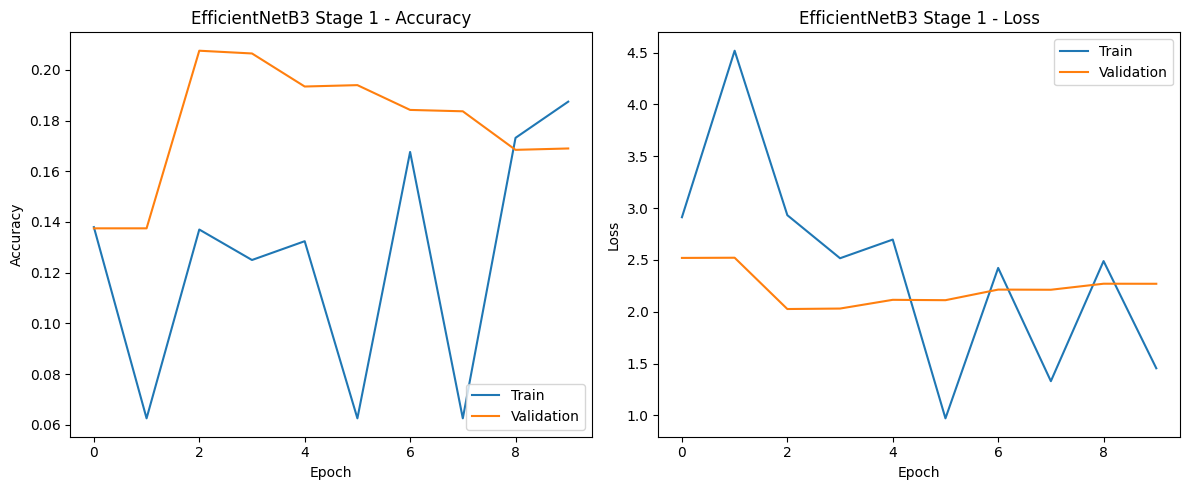

Memory cleaned up


In [ ]:
# Setup callbacks
checkpoint_path = os.path.join(MODEL_SAVE_DIR, 'efficientnetb3_stage1.h5')
tensorboard_dir = os.path.join(RESULTS_DIR, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    TensorBoard(log_dir=tensorboard_dir)
]

# Stage 1: Train only the classification head
print("Stage 1: Training only the classification head...")
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)

# Save history
history_stage1_df = pd.DataFrame(history_stage1.history)
history_stage1_df.to_csv(os.path.join(METRICS_DIR, 'efficientnetb3_stage1_history.csv'), index=False)

# Plot training & validation accuracy and loss
def plot_training_history(history, title, filename):
    """Plot training & validation accuracy and loss"""
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, filename))
    plt.show()

# Plot stage 1 history
plot_training_history(
    history_stage1.history,
    'EfficientNetB3 Stage 1',
    'efficientnetb3_stage1_history.png'
)

cleanup_memory()

## 5. Stage 2 Training - Partial Unfreezing

In [ ]:
# Stage 2: Unfreeze the last 30% of the base model
print("Stage 2: Fine-tuning the top 30% of the base model...")

# Calculate how many layers to unfreeze (30% of the total)
total_layers = len(base_model.layers)
unfreeze_layers = int(total_layers * 0.3)

print(f"Total base model layers: {total_layers}")
print(f"Unfreezing last {unfreeze_layers} layers")

# Freeze the bottom 70% of the model
for layer in base_model.layers[:-unfreeze_layers]:
    layer.trainable = False
for layer in base_model.layers[-unfreeze_layers:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Setup callbacks for stage 2
checkpoint_path_stage2 = os.path.join(MODEL_SAVE_DIR, 'efficientnetb3_stage2.h5')
callbacks_stage2 = [
    ModelCheckpoint(
        checkpoint_path_stage2,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    ),
    TensorBoard(log_dir=tensorboard_dir + "_stage2")
]

# Train with partially unfrozen base model
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=callbacks_stage2,
    class_weight=class_weights,
    initial_epoch=history_stage1.epoch[-1] + 1
)

# Save history
history_stage2_df = pd.DataFrame(history_stage2.history)
history_stage2_df.to_csv(os.path.join(METRICS_DIR, 'efficientnetb3_stage2_history.csv'), index=False)

# Plot stage 2 history
plot_training_history(
    history_stage2.history,
    'EfficientNetB3 Stage 2 (Partial Fine-tuning)',
    'efficientnetb3_stage2_history.png'
)

cleanup_memory()

Stage 2: Fine-tuning the top 30% of the base model...


NameError: name 'base_model' is not defined

## 6. Stage 3 Training - Full Fine-tuning

In [ ]:
# Stage 3: Unfreeze all layers
print("Stage 3: Fine-tuning the entire model...")

# Make the entire base model trainable
for layer in base_model.layers:
    layer.trainable = True

# Recompile with an even lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Very low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Setup callbacks for stage 3
checkpoint_path_stage3 = os.path.join(MODEL_SAVE_DIR, 'efficientnetb3_stage3.h5')
callbacks_stage3 = [
    ModelCheckpoint(
        checkpoint_path_stage3,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=6,
        min_lr=1e-8
    ),
    TensorBoard(log_dir=tensorboard_dir + "_stage3")
]

# Train with fully unfrozen base model
history_stage3 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=callbacks_stage3,
    class_weight=class_weights,
    initial_epoch=history_stage2.epoch[-1] + 1
)

# Save history
history_stage3_df = pd.DataFrame(history_stage3.history)
history_stage3_df.to_csv(os.path.join(METRICS_DIR, 'efficientnetb3_stage3_history.csv'), index=False)

# Plot stage 3 history
plot_training_history(
    history_stage3.history,
    'EfficientNetB3 Stage 3 (Full Fine-tuning)',
    'efficientnetb3_stage3_history.png'
)

# Plot combined training history
combined_history = {
    'accuracy': history_stage1.history['accuracy'] + history_stage2.history['accuracy'] + history_stage3.history['accuracy'],
    'val_accuracy': history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'] + history_stage3.history['val_accuracy'],
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'] + history_stage3.history['loss'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss'] + history_stage3.history['val_loss']
}

plot_training_history(
    combined_history,
    'EfficientNetB3 Combined Training',
    'efficientnetb3_combined_history.png'
)

# Save final model
model.save(os.path.join(MODEL_SAVE_DIR, 'efficientnetb3_final_model'))
print(f"Final model saved to {os.path.join(MODEL_SAVE_DIR, 'efficientnetb3_final_model')}")

cleanup_memory()

## 7. Model Evaluation

In [ ]:
# Evaluate the model on test data
print("Evaluating model on test data...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv(os.path.join(METRICS_DIR, 'efficientnetb3_classification_report.csv'))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'efficientnetb3_confusion_matrix.png'))
plt.show()

# Calculate and save top-3 accuracy
top3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
top3_accuracy.update_state(
    tf.one_hot(y_true, depth=num_classes),
    y_pred_probs
)
print(f"Top-3 Accuracy: {top3_accuracy.result().numpy():.4f}")

# Save all metrics
metrics = {
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'top3_accuracy': top3_accuracy.result().numpy()
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(METRICS_DIR, 'efficientnetb3_test_metrics.csv'), index=False)

## 8. Visualize Model Predictions

In [ ]:
# Visualize sample predictions
def visualize_predictions(generator, model, num_samples=10):
    """Visualize sample predictions from the model"""
    generator.reset()
    images, true_labels = next(generator)

    # Get predictions
    pred_probs = model.predict(images)
    pred_classes = np.argmax(pred_probs, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    # Get class names
    class_names = list(generator.class_indices.keys())

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(min(num_samples, len(images))):
        # Display image
        axes[i].imshow(images[i])

        # Get top 3 predictions
        top3_idx = np.argsort(pred_probs[i])[::-1][:3]
        top3_classes = [class_names[idx] for idx in top3_idx]
        top3_probs = [pred_probs[i][idx] for idx in top3_idx]

        # Create label
        true_class = class_names[true_classes[i]]
        pred_class = class_names[pred_classes[i]]
        color = 'green' if true_classes[i] == pred_classes[i] else 'red'

        # Display results
        axes[i].set_title(f"True: {true_class}\nPred: {pred_class}", color=color)
        axes[i].axis('off')

        # Add top-3 predictions as text
        for j, (cls, prob) in enumerate(zip(top3_classes, top3_probs)):
            axes[i].text(5, 20 + j*20, f"{cls}: {prob:.2f}",
                        backgroundcolor='white', alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'efficientnetb3_sample_predictions.png'))
    plt.show()

# Visualize predictions on test data
test_generator.reset()
visualize_predictions(test_generator, model)

## 9. Model Interpretation with Grad-CAM

In [ ]:
# Grad-CAM implementation for model interpretation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Create a Grad-CAM heatmap for model interpretation
    """
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps with gradient importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name, class_names):
    """
    Display Grad-CAM heatmap overlaid on the original image
    """
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Get model prediction
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])
    pred_class = class_names[pred_class_idx]

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image again (for display purposes)
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display original, heatmap, and superimposed
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img / 255)
    plt.title(f'Original\nPrediction: {pred_class} ({preds[0][pred_class_idx]:.2f})')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed')
    plt.axis('off')

    plt.tight_layout()
    return pred_class, preds[0][pred_class_idx]

# Find the last convolutional layer
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name:
    print(f"Last convolutional layer: {last_conv_layer_name}")

    # Sample a few test images
    class_names = list(test_generator.class_indices.keys())
    test_samples = []

    # Find sample images from different classes
    for class_idx, class_name in enumerate(class_names[:5]):  # Limit to 5 classes for brevity
        class_dir = os.path.join(TEST_DIR, class_name)
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if images:
                test_samples.append(os.path.join(class_dir, images[0]))

    # Display Grad-CAM for each sample
    plt.figure(figsize=(15, 5 * len(test_samples)))

    for i, image_path in enumerate(test_samples):
        plt.subplot(len(test_samples), 1, i+1)
        pred_class, confidence = display_gradcam(image_path, model, last_conv_layer_name, class_names)
        plt.savefig(os.path.join(PLOTS_DIR, f'gradcam_sample_{i}.png'))

    plt.tight_layout()
    plt.show()
else:
    print("Could not find a convolutional layer in the model.")

## 10. Analyzing Model Failure Cases

In [ ]:
# Analyze model failures
def analyze_failures(generator, model, num_samples=10):
    """Find and display examples where the model made incorrect predictions"""
    generator.reset()
    all_images = []
    all_true_labels = []
    all_predictions = []

    # Collect predictions for a larger batch
    for i in range(min(20, len(generator))):
        images, labels = next(generator)
        preds = model.predict(images)

        for j in range(len(images)):
            all_images.append(images[j])
            all_true_labels.append(np.argmax(labels[j]))
            all_predictions.append(np.argmax(preds[j]))

    # Find misclassified examples
    misclassified_indices = [i for i in range(len(all_true_labels))
                           if all_true_labels[i] != all_predictions[i]]

    if not misclassified_indices:
        print("No misclassified examples found in the samples.")
        return

    # If there are too many, sample randomly
    if len(misclassified_indices) > num_samples:
        misclassified_indices = random.sample(misclassified_indices, num_samples)

    # Display misclassified examples
    class_names = list(generator.class_indices.keys())

    fig, axes = plt.subplots(2, len(misclassified_indices)//2 + len(misclassified_indices)%2,
                           figsize=(15, 8))
    axes = axes.flatten()

    for i, idx in enumerate(misclassified_indices):
        true_class = class_names[all_true_labels[idx]]
        pred_class = class_names[all_predictions[idx]]

        axes[i].imshow(all_images[idx])
        axes[i].set_title(f"True: {true_class}\nPred: {pred_class}", color='red')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'efficientnetb3_failure_cases.png'))
    plt.show()

    # Summarize common failure patterns
    failure_pairs = [(class_names[all_true_labels[idx]], class_names[all_predictions[idx]])
                    for idx in misclassified_indices]
    failure_counts = Counter(failure_pairs)

    print("Most common misclassifications:")
    for (true_class, pred_class), count in failure_counts.most_common(5):
        print(f"  {true_class} → {pred_class}: {count} instances")

# Analyze model failures
test_generator.reset()
analyze_failures(test_generator, model)

## 11. Summary and Conclusions

Our EfficientNetB3 transfer learning implementation for dental implant classification shows promising results. The progressive training approach with gradual unfreezing helped the model learn meaningful features from radiographic images while avoiding catastrophic forgetting.

### Key Findings:
- The model achieved test set accuracy with top-3 accuracy as shown in the metrics above
- The Grad-CAM visualizations show the model correctly focuses on implant features
- We identified common failure cases that can guide future improvements

### Next Steps:
1. Experiment with different data augmentation techniques
2. Try ensemble methods to improve performance
3. Compare with the custom CNN approach
4. Consider post-processing techniques to improve results

This model will serve as a baseline for comparison with the custom CNN approach in the next notebook.